# A study case on climate time series analysis: monitoring and forecasting the atmospheric temperature in Vancouver

A climate can be defined as a statistical description of long-term weather patterns, in a given location, in terms of meteorological variables, such as temperature, humidity, precipitation and others. Time series of the aforementioned variables are strongly non-stationary due to their dependence on the seasons of the year. As a consequence of this seasonality, the expected values of meteorological variables are functions of time.

Monitoring and forecasting approaches of climate data must take its non-stationarity into account. These issues were addressed in the current work. The occurrence of anomalies in the atmospheric temperature of a location in Vancouver was monitored by comparing a daily average temperature time series with a respective exponentially weighted moving average (EWMA) time series. The forecasting, on its role, was based in a monthly average temperature time series and employed a seasonal autoregressive integrated moving average (SARIMA) model.

The data used in this work was obtained through an API provided by the meteostat Python library, which furnishes data from an open database (also named as Meteostat) containing measurements from meteorological stations all along the world. The Apache Spark SQL module was employed with the aim to manipulate the datasets requested from the API. This module was used since it  allows the execution of SQL queries within the Python script and yields an improving in the querying performance by optimizing the queries with the Spark Catalyst optimizer.

The following code cells present the installation of the pyspark and meteostat libraries and the importing of the other libraries used in this work. Their applications are discussed with more details in the next sections.

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 29 kB/s 
     |████████████████████████████████| 198 kB 42.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=1e005fe10cf5fa303e3a2962c3d2ed9e43fce55c90a7e9244970741b379fa28b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
!pip install meteostat

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['lines.markersize'] = 10

## Anomaly detection in the daily average temperature time series

In a stationary time series with normal distribution $x_t$ ~ $\mathcal{N}(\mu, \sigma^2)$, approximately 68, 95 and 99.7% of the observations are comprised between $\pm$1, $\pm$2 and $\pm$3 standard deviations $\sigma$ from the expected value $\mu$, respectively. This means that only 0.3% of the observations lie beyond three standard deviations and, as consequence, they are not likely to happen oftenly in a small time interval. Thus, observations more than $3\sigma$ from the expected value $\mu$ can be considered anomalies. In this work, the terms anomalies and outliers were used interchangeably.

Nonetheless, meteorological time series exhibit seasonal behaviors within long time intervals. Due to this, it is not possible to simply compare the distribution of the observations with a mean value$\mu$. The expected value of the atmospheric temperature is time dependent and exhibits a periodicity with frequency 1/365 $\approx$ 0.00274 (1/day). Since the daily average temperature time series gravitates around this time dependent expected value, it is possible to detect anomalous behaviors based in the difference between these time series.

An EWMA time series was used as an estimate of the daily average temperature expected value. This moving average is given recursively by:
$$
\text{EWMA}_t = \lambda x_t + (1 - \lambda)\text{EWMA}_{t - 1} = \sum_{i = 1}^{\infty}\lambda^ix_{t - i}
$$
where $\lambda \in (0, 1]$ is a weighting factor. It is easy to verify that the EWMA time series corresponds to the infinite impulse response (IIR) filtering of the time series $x_t$. In the $\mathcal{Z}$ transform notation, we have:
$$
\text{EWMA}(z) = H(z)X(z) = \frac{\lambda}{1 - (1 - \lambda)z^{-1}}X(z)
$$
with gain $\lambda$ and pole at $z = 1 - \lambda$. Thereby, the parameter $\lambda$ determines the cut-off frequency of the IIR filter $H(z)$. A large value of $\lambda$ gives more weight to recent data and less to old data, coinciding with a larger cut-off frequency. A small value of $\lambda$, on the other hand, gives more weight to older data and corresponds to a smaller cut-off frequency. As a rule of thumb, to obtain an EWMA statistic based on the last $N$ observations, the parameter $\lambda$ is set to:
$$
\lambda = \frac{2}{N + 1}
$$

The difference between the time series $x_t$ and the EWMA time series can be assumed as stationary and occurrence of anomalies can be investigated in terms of the distance from the average value. The data used in this analysis was collected from the location in Vancouver, specified in the next code cell, between 1 January 2006 and 31 March 2022. It is possible to see that the dataset contains another variables, like the precipitation level time series. But only the daily average temperature was addressed.

In [4]:
start = datetime(2006, 1, 1)
end = datetime(2022, 3, 31)

location = Point(49.2497, -123.1193, 70)

data = Daily(location, start, end)
data = data.fetch()

data = data.rename_axis('date').reset_index()
data.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2006-01-01,8.4,7.2,9.5,3.8,0.0,NaN,NaN,NaN,NaN,NaN
1,2006-01-02,7.3,6.0,8.6,0.6,0.0,NaN,NaN,NaN,NaN,NaN
2,2006-01-03,6.6,4.8,8.3,6.4,0.0,NaN,NaN,NaN,NaN,NaN
3,2006-01-04,8.1,5.5,10.6,1.8,0.0,93.0,17.6,NaN,1024.0,NaN
4,2006-01-05,8.6,7.4,9.8,21.8,0.0,NaN,NaN,NaN,NaN,NaN


Before running any PySpark application it is necessary to initialize the SparkSession.

In [5]:
spark = SparkSession.builder.getOrCreate()

The following code cell show the registering of the dataframe as a table, named daily_avg_table, where the queries were executed. The calculation of the EWMA time series was done by means of the pandas.DataFrame.ewm() class. The mean values of this statistic are returned by the user defined function (UDF) ewma(). As can be seen, the EWMA statistic is based in the observations along the previous month ($N$ = 31). This corresponds, in the pandas.DataFrame.ewm() class, to setting the span parameter to 31.

PySpark allows the invoking of UDFs within the SQL query, as can be seen below. The query is structured in a string and executed in the SparkSession, returning the dataframe res_df. This last dataframe was also registered as a table in order to query the outliers in the data.

In [6]:
df = spark.createDataFrame(data)
df = df.createOrReplaceTempView("daily_avg_temp")

DAYS_PER_MONTH = 31

@pandas_udf("float")
def ewma(s: pd.Series) -> pd.Series:
  return pd.DataFrame.ewm(s, span = DAYS_PER_MONTH, adjust = False).mean()

spark.udf.register("ewma", ewma)

query = """
        SELECT
          tab1.date,
          tab1.tavg,
          ewma(tab1.tavg) AS ewma_temp,
          (tab1.tavg - ewma(tab1.tavg)) AS diff_temp
        FROM
          daily_avg_temp AS tab1
        """

res_df = spark.sql(query)
res_df.createOrReplaceTempView("res_table")
df = res_df.toPandas()
df

,date,tavg,ewma_temp,diff_temp
0,2006-01-01,8.4,8.400000,3.814697e-07
1,2006-01-02,7.3,8.331250,-1.031250e+00
2,2006-01-03,6.6,8.223047,-1.623047e+00
3,2006-01-04,8.1,8.215357,-1.153568e-01
4,2006-01-05,8.6,8.239397,3.606030e-01
...,...,...,...,...
5929,2022-03-27,10.0,6.951068,3.048932e+00
5930,2022-03-28,10.1,7.147876,2.952124e+00
5931,2022-03-29,10.0,7.326134,2.673866e+00
5932,2022-03-30,9.1,7.437000,1.663000e+00


The outliers were divided between two sets. The ones with absolute value between three and four standard deviations from the expected values ($\mu + 3\sigma \leq |x_t - \text{EWMA}_t| < \mu + 4\sigma$), and the ones more than four standard deviations from the expected values ($|x_t - \text{EWMA}_t| \geq \mu + 4\sigma$). They were denominated rank 3 and rank 4+ outliers, respectively. In a daily basis, a rank 3 outlier is expected to happen yearly and a rank 4+ outlier is expected to happen at each 43 years. Thus, their occurrence can signalize anomalous behaviors in the daily average temperature time series.

In [7]:
query = """
        SELECT
          res_table.date, res_table.tavg
        FROM
          res_table
        WHERE
          (ABS(res_table.diff_temp) >= (
            SELECT
              AVG(tab1.diff_temp) + 3*STDDEV_POP(tab1.diff_temp)
            FROM
              res_table AS tab1
          )) AND (ABS(res_table.diff_temp) < (
            SELECT
              AVG(tab2.diff_temp) + 4*STDDEV_POP(tab2.diff_temp)
            FROM
              res_table AS tab2
          ))
        """

rank_3_outliers = spark.sql(query).toPandas()

query = """
        SELECT
          res_table.date, res_table.tavg
        FROM
          res_table
        WHERE
          ABS(res_table.diff_temp) >= (
            SELECT
              AVG(tab1.diff_temp) + 4*STDDEV_POP(tab1.diff_temp)
            FROM
              res_table AS tab1
          )
        """

rank_4_outliers = spark.sql(query).toPandas()

The results of the monitoring approach are presented in the next figure. Although the time series covers a period of approximately 16 years, it comprises seven anomalies of rank 4+. Several rank 3 anomalies can also be observed in periods smaller than one year. These are good indicatives of anomalous behaviors.

As can be verified, most of these anomalies are associated with temperatures smaller than the expected value. Indeed, the last rank 4+ anomaly in the time series happened during one of the coldest Decembers in recorded story in Vancouver. The phenomenon was caused by an unusual extended stretch of Arctic air (ALI, 2021). The anomalies associated with temperatures higher than the expected value also match with historical data. According to Lindsay (2015), in the years of 2006 and 2008, during the summer season, excessively high temperatures (compared with historical data) were registered in several locations across British Columbia.

The anomaly detected during the summer of 2021 was associated with a head wave that affected all the Western North America between June and July of this year. In British Columbia, it was responsible for record temperatures above 40 ºC and nearly 600 deaths (SCHMUNK, 2021). According to Rosenthal (2021), the phenomenon behind the anomaly was a head dome cause by a high pressure system, trapped by a large poleward shift in the atmospheric jet stream, along the Pacific coast in Canada and in the USA. Although heat domes are a periodic phenomenon in Pacific Northwest, the intensity of this one may be linked to climate change. Still according to Rosenthal (2021), it is expected that the increase of temperatures, due to global warming, may cause the atmospheric jet streams to move wavy, causing them to exhibit large deviations and, as consequence, extreme heat events may become more common.

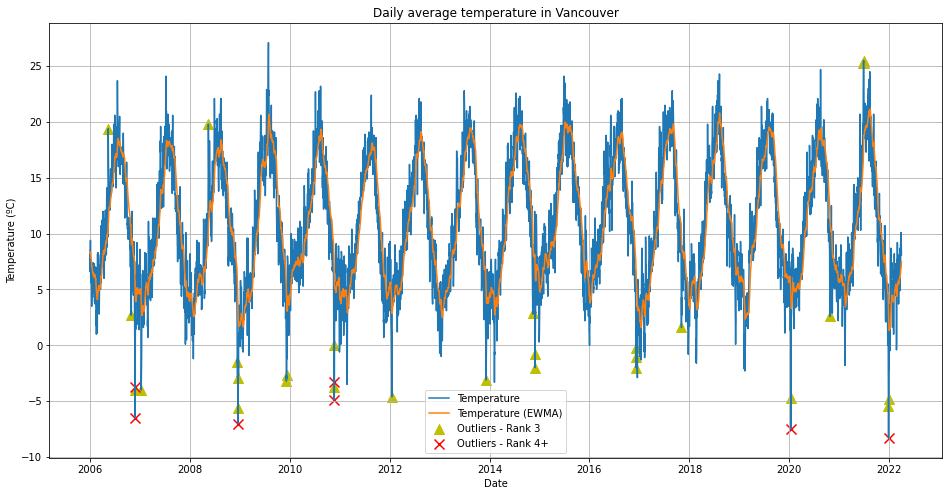

In [8]:
_ = plt.figure()
plt.plot(df['date'], df['tavg'], label = 'Temperature')
plt.plot(df['date'], df['ewma_temp'], label = 'Temperature (EWMA)')
plt.scatter(rank_3_outliers['date'], rank_3_outliers['tavg'], color = 'y',
            marker = '^', label = "Outliers - Rank 3")
plt.scatter(rank_4_outliers['date'], rank_4_outliers['tavg'], color = 'r',
            marker = 'x', label = "Outliers - Rank 4+")
plt.legend(loc = 'lower center')
plt.ylabel('Temperature (ºC)')
plt.xlabel('Date')
plt.title('Daily average temperature in Vancouver')
plt.show()

As it was presented, the anomalies detected in the last figure can associated with meteorological phenomena in the registered history. The monitoring of the temperature time series by mean of its deviation from an EWMA time series provides a statistical way to determine with which extend a given observation is anomalous. The method can be used to achieve a deeper comprehension about meteorological records and how much the climate change induces deviations in the climate.

## Forecasting the monthly average temperature time series

The data used to model the atmospheric temperature corresponds to a time series with the average values of each month between January of 2006 and March of 2022. It was obtained through the following SQL query and stored and the month_df dataframe. This data is non-stationary due to a seasonal component with periodicity of 12 time intervals. Due to this, SARIMA models were employed instead of simple autoregressive moving average (ARMA) models (which are suitable for stationary time series).

SARIMA models are generalizations of the ARMA models for non-stationary time series. They stationarize these time series by mean of simple and seasonal differentiations (i. e., $\nabla = 1 - z^{-1}$ and $\nabla_s = 1 - z^{-s}$). For instance, the seasonal differentiation of the time series $x_t$ furnishes:
$$
\nabla_s x_t = (1 - z^{-s})x_t = x_t - x_{t - s}
$$
Although the former equation mixes $\mathcal{Z}$ transform notation and time series notation, it is important to notice that the expression $(1 - z^{-s})x_t$ does not imply in the multiplication between the operator $(1 - z^{-s})$ and the time series $x_t$. The expression corresponding to the subtraction of the time series values by values delayed $s$ time intervals. This mixed notation will be employed along this work since it simplifies the discussion about the SARIMA models.

According to Box at al. (2016), the SARIMA model describes the dynamics of the stationarized time series by means of autoregressive and moving average operators, $\phi_p(z^{-1})$ and $\theta_q(z^{-1})$, and seasonal autoregressive and moving average operators, $\Phi_P(z^{-s})$ and $\Theta_Q(z^{-s})$, and assumes it to be driven a succession of random peaks. In the multiplicative form, it is given by the equation:
$$
\phi_p{\big (}z^{-1}{\big )}\Phi_P{\big (}z^{-s}{\big )}\nabla^d\nabla_s^Dx_t = \theta_0 + \theta_q{\big (}z^{-1}{\big )}\Theta_Q{\big (}z^{-s}{\big )}a_t
$$
where $a_t$ is a zero mean white noise signal. The indices $p$, $P$, $q$ and $Q$ and the exponents $d$ and $D$ correspond to the polynomial orders of the respective operators. A SARIMA model described by the former equation can be denoted by SARIMA$(p, d, q)\times (P, D, Q)_s$. The term $\theta_0$, on its role, is a non-zero constant when the time series exhibits deterministic behaviors and equals to zero when it is purely stochastic.

In [9]:
query = """
        SELECT
          to_timestamp(date_format(tab1.date, "yyyy-MM")) AS date,
          AVG(tab1.tavg) AS tavg
        FROM
          res_table AS tab1
        GROUP BY
          date_format(tab1.date, "yyyy-MM")
        ORDER BY
          date_format(tab1.date, "yyyy-MM")
        """

month_df = spark.sql(query).toPandas()
month_df

,date,tavg
0,2006-01-01,6.129032
1,2006-02-01,4.489286
2,2006-03-01,6.674194
3,2006-04-01,9.500000
4,2006-05-01,12.625806
...,...,...
190,2021-11-01,7.576667
191,2021-12-01,2.151613
192,2022-01-01,4.400000
193,2022-02-01,5.103571


The temperature time series analyzed in this work exhibit no visible trend. Thus, only a seasonal differentiation (with $s$ = 12) was applied. The augmented Dickley-Fuller (ADF) test was used with the aim to verify if the differentied time series is stationary. This test takes by null hypothesis that the time series can be described by a trend. If this hypothesis is rejected the time series can be assumed as stationary.

In terms of a p-value, the null hypothesis is rejected when the p-value is inferior to a given threshold. As can be seen, the ADF test produced a p-value much smaller than 0.01. This implies that is possible to reject the null hypothesis with more than 99% of accuracy.

In [10]:
def diff(data, interval = 1):
  res = list()
  for i in range(interval, len(data)):
    res.append(data[i] - data[i - interval])
  return pd.Series(res)

x = diff(month_df['tavg'], interval = 12)

res = adfuller(x)
print('ADF p-value: ', res[1])

ADF p-value:  3.944084229910877e-05


Since the autocorrelation and partial autocorrelation functions (ACF and PACF) are measures of the interdependence between the observations in different time intervals, they can be used to estimate the order of the autoregressive and moving average operators. When the ACF presents an exponential decaying and the PACF drops to zero abruptly after a given lag, the time series as said to have an autoregressive signature. On the other hand, when the exponential decaying is observed in the PACF and the ACF has an abrupt cut-off, the time series is said to have a moving average signature.

Unfortunately it is not possible to identify if the ACF and PACF of the differentiated time series $\nabla_{12}x_t$ has autoregressive or moving average signature. Both of them drop to zero after lag 1 and exhibit negative peaks at lags 12 and 24. In the modeling approach the peak at lag 1 was assumed to be due to autoregressive behaviors and the seasonal peaks were hypothesized to be due to second order autoregressive, second order moving average or mixed autoregressive-moving average behaviors. Thereby, the models SARIMA$(1, 0, 0)\times (2, 1, 0)_{12}$, SARIMA$(1, 0, 0)\times (0, 1, 2)_{12}$ and SARIMA$(1, 0, 0)\times (2, 1, 2)_{12}$ were considered.

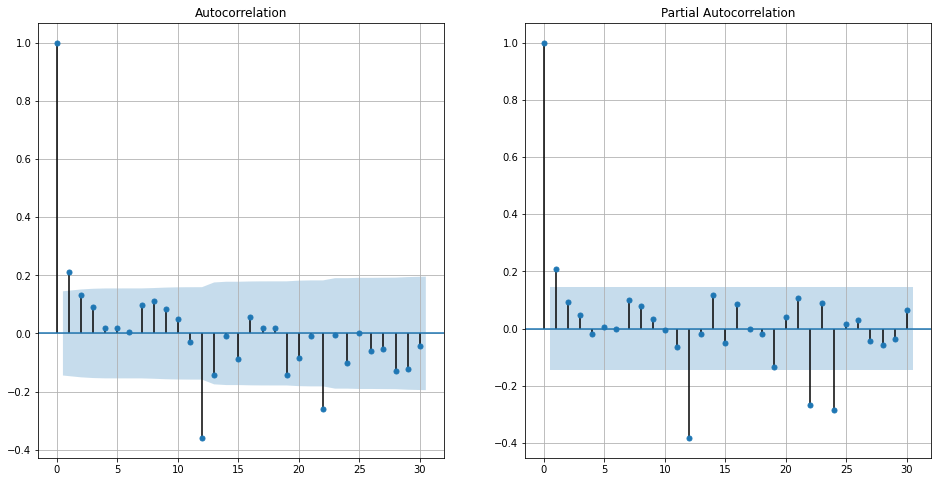

In [11]:
_, ax = plt.subplots(1, 2)
plot_acf(x, ax = ax[0], lags = 30) 
plot_pacf(x, ax = ax[1],lags = 30, method = 'ywm')
plt.show()

In order to evaluate the modeling approach for the three candidate models, only observations up to March of 2021 were used during their training. The accuracy of the model on forecasting the observations between March of 2021 and March of 2022 (prediction horizon), as well as the consistency of the models (in terms of the correlation of squared residues), were used to choose the more suitable between them.

The modeling was done using the statsmodels.tsa.statespace.sarimax.SARIMAX() class. This class fit the parameters of the autoregressive and moving average operators by maximizing the logarithm of a likelihood function. The SARIMAX.fit() method computes the first order and the second order partial derivatives of the log likelihood function to determine the optimum set of parameters.

The following script converged successfully to an optimum set of parameters, with log likelihood equals to -289.201. The obtained SARIMA$(1, 0, 0)\times(2, 1, 0)_{12}$ model is given by the equation:
$$
{\big (}1 - 0.2283z^{-1}{\big )}{\big (}1 + 0.4953z^{-12} + 0.3257z^{-24}{\big )}\nabla_{12}x_t = 0.0829 + a_t
$$

In [12]:
endog = month_df['tavg'].loc[month_df['date'] <= datetime(2021, 3, 1)]
endog_date = month_df['date'].loc[month_df['date'] <= datetime(2021, 3, 1)]

sarima = SARIMAX(endog, trend = 'c', order = (1, 0, 0),
                 seasonal_order = (2, 1, 0, 12)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               tavg   No. Observations:                  183
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -289.201
Date:                            Fri, 15 Apr 2022   AIC                            588.402
Time:                                    23:55:37   BIC                            604.111
Sample:                                         0   HQIC                           594.776
                                            - 183                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0829      0.108      0.770      0.441      -0.128       0.294
ar.L1          0.2283      0.073      3.134      0.002       0.086       0.371
ar.S.L12      -0.4953      0.079     -6.269      0.000      -0.650      -0.340
ar.S.L24      -0.3275      0.066     -4.966      0.000      -0.457      -0.198
sigma2         1.6784      0.164     10.209      0.000       1.356       2.001
===================================================================================
Ljung-Box (Q):                       74.42   Jarque-Bera (JB):                 4.35
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.87   Skew:                             0.19
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It is possible to that most of the real values in the prediction horizon (labels) lie in the confidence interval (95%) of the forecasts of this model. However, according to the Ljung-Box test, this model does not represent consistently the historical data. The Ljung-Box test measures the goodness-of-fit of the model in terms of the squared values of the ACF function of the model residues. The test is based in the statistic:
$$
Q = n(n + 2)\sum_{k = 1}^h\frac{\rho_k^2}{n - k}
$$
where $\rho_k$ is the ACF value at lag $k$ and $h$ is the number of lags considered in the test. Usually, the first 10 to 20 autocorrelations of the residues series are used to test the inadequacy of the model. The statsmodels functions use the first 10. According to Box et al. (2016), the distribution of the statistic $Q$ converges to a chi-squared distribution $\chi^2(h)$ as the number of observations $n$ goes to infinity. When $Q$ assumes a big value it is an indicative that the residues may be correlated. In terms of the p-value, it corresponds to a p-value under a given threshold. In this work, a threshold of $p(Q) = 0.05$ was used to confirm the inadequacy of the models.

As far as the Ljung-Box method presented p-value equals to zero it is possible to say that the residues are correlated and the SARIMA$(1, 0, 0)\times (2, 1, 0)_{12}$ fails on describing the monthly average time series.

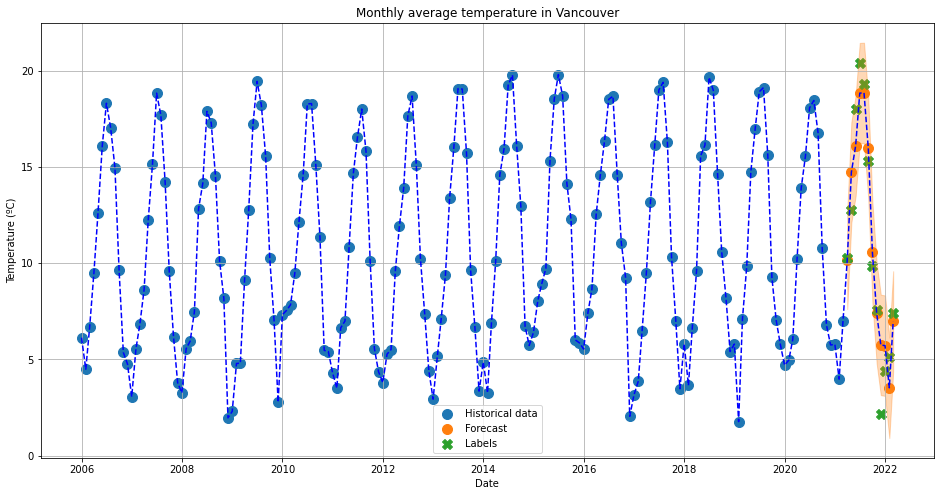

In [13]:
predict = sarima.get_forecast(steps = 12).summary_frame(alpha = .05)
res = pd.concat([endog, predict['mean']])

predict_date = pd.Series(
    pd.date_range(datetime(2021, 4, 1),
                  datetime(2022, 4, 1), freq = 'm')).apply(
                      lambda d: d.replace(day = 1))
                 
labels = month_df['tavg'].loc[month_df['date'] > datetime(2021, 3, 1)]
labels_date = month_df['date'].loc[month_df['date'] > datetime(2021, 3, 1)]

_, ax = plt.subplots()
plt.scatter(endog_date, endog, label = 'Historical data')
plt.scatter(predict_date, predict['mean'], label = 'Forecast')
plt.scatter(labels_date, labels, marker = 'X', label = 'Labels')
plt.plot(pd.concat([endog_date, predict_date]), res, 'b--')
plt.legend(loc = 'lower center')
plt.xlabel('Date')
plt.ylabel('Temperature (ºC)')
plt.title('Monthly average temperature in Vancouver')
ax.fill_between(predict_date, predict['mean_ci_lower'],
                predict['mean_ci_upper'], color='tab:orange', alpha = 0.3);
plt.show()

The mean absolute deviation (MAD), mean squared error (MSE) and mean absolute percentage error (MAPE) of the residues were also used to compare the results of the modeling approach. These measures are given by:
$$
\text{MAD} = \frac{1}{n}\sum_{k = 1}^{n}|x_k - \hat{x}_k|, \text{ MSE} = \frac{1}{n}\sum_{k = 1}^{n}(x_k - \hat{x}_k)^2, \text{ MAPE} = \frac{1}{n}\sum_{k = 1}\frac{|x_k - \hat{x}_k|}{|x_k|}
$$
The MAD, MSE and MAPE of the forecasts in the last figure were approximately 1.204 ºC, 2.372 ºC² and 23.72%. As it is shown further in this section, consistent models present better error measures.

In [14]:
res = (labels - predict['mean']).values

print('MAD: ', np.mean(np.abs(res)), 'ºC')
print('MSE:', np.mean((res)**2), 'ºC²')
print('MAPE: ', 100*np.mean(np.abs(res)/labels.values), '%')

MAD:  1.2046943893539954 ºC
MSE: 2.3721678869491067 ºC²
MAPE:  23.73404044314129 %


The SARIMA$(1, 0, 0)\times (0, 1, 2)_{12}$ model converged to an optimum set of parameters with correspondent log likelihood equals to -74.547. Different from the previous case, the residues of this model presented Ljung-Box statistic considerably inferior ($Q$ = 45.41) and a p-value of 0.26. Therefore, the model given by the equation:
$$
{\big (}1 - 0.2341z^{-1}{\big )}\nabla_{12}x_t = 0.0586 + {\big (}1 + 0.8437z^{-12} + 0.1549z^{-24}{\big )}a_t
$$
furnishes an adequate description of the monthly average temperature time series.

In [15]:
sarima = SARIMAX(endog, trend = 'c', order = (1, 0, 0),
                 seasonal_order = (0, 1, 2, 12)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               tavg   No. Observations:                  183
Model:             SARIMAX(1, 0, 0)x(0, 1, 2, 12)   Log Likelihood                -274.547
Date:                            Fri, 15 Apr 2022   AIC                            559.095
Time:                                    23:55:43   BIC                            574.803
Sample:                                         0   HQIC                           565.468
                                            - 183                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0586      0.025      2.374      0.018       0.010       0.107
ar.L1          0.2341      0.072      3.259      0.001       0.093       0.375
ma.S.L12      -0.8437      8.003     -0.105      0.916     -16.530      14.843
ma.S.L24      -0.1549      1.304     -0.119      0.905      -2.711       2.401
sigma2         1.2215      9.763      0.125      0.900     -17.913      20.356
===================================================================================
Ljung-Box (Q):                       45.41   Jarque-Bera (JB):                 5.34
Prob(Q):                              0.26   Prob(JB):                         0.07
Heteroskedasticity (H):               0.90   Skew:                            -0.12
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Again, most of labels lie within the confidence interval of the forecasts. Similarly to the results of the SARIMA$(1, 0, 0)\times (2, 1, 0)_{12}$, the only label out of the confidence interval corresponds to the observations from December of 2021. It is easy to understand the failure of the model on forecasting the temperature for this time step given the anomaly detected during this period in the last section. The hypothesis of seasonality does not cover this anomalous behavior as far as it corresponds to a huge deviation from the expected value of the time series.

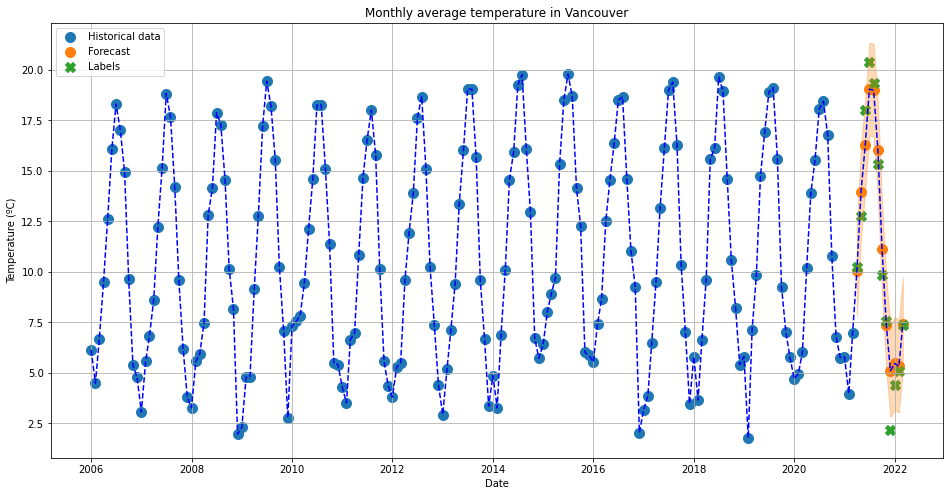

In [16]:
predict = sarima.get_forecast(steps = 12).summary_frame(alpha = .05)
res = pd.concat([endog, predict['mean']])

_, ax = plt.subplots()
plt.scatter(endog_date, endog, label = 'Historical data')
plt.scatter(predict_date, predict['mean'], label = 'Forecast')
plt.scatter(labels_date, labels, marker = 'X', label = 'Labels')
plt.plot(pd.concat([endog_date, predict_date]), res, 'b--')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Temperature (ºC)')
plt.title('Monthly average temperature in Vancouver')
ax.fill_between(predict_date, predict['mean_ci_lower'],
                predict['mean_ci_upper'], color='tab:orange', alpha = 0.3);
plt.show()

The error measures (MAD = 0.9387 ºC, MSE = 1.533 ºC² and MAPE = 18.00%) evidenced a significant improvement, specially the MSE and MAPE measures.

In [17]:
res = (labels - predict['mean']).values

print('MAD: ', np.mean(np.abs(res)), 'ºC')
print('MSE:', np.mean((res)**2), 'ºC²')
print('MAPE: ', 100*np.mean(np.abs(res)/labels.values), '%')

MAD:  0.9387077805713474 ºC
MSE: 1.533343197752992 ºC²
MAPE:  17.99818989855174 %


The SARIMA$(1, 0, 0)\times (2, 1, 2)_{12}$ model, given by the equation:
$$
{\big (}1 - 0.2533z^{-1}{\big )}{\big (}1 - 0.4431z^{-12} + 0.2077z^{-24}{\big )}\nabla_{12}x_t = 0.0462 + {\big (}1 + 1.2244z^{-12} - 0.3506z^{-24}{\big )}a_t
$$
also achieved an optimum set of parameters, with log likelihood equals to -273.451, and was able to describe adequately the temperature time series. The Ljung-Box statistic presented value $Q$ = 39.44 and p-value 0.50.

In [18]:
sarima = SARIMAX(endog, trend = 'c', order = (1, 0, 0),
                 seasonal_order = (2, 1, 2, 12)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               tavg   No. Observations:                  183
Model:             SARIMAX(1, 0, 0)x(2, 1, 2, 12)   Log Likelihood                -273.451
Date:                            Fri, 15 Apr 2022   AIC                            560.902
Time:                                    23:55:49   BIC                            582.894
Sample:                                         0   HQIC                           569.825
                                            - 183                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0462      0.035      1.320      0.187      -0.022       0.115
ar.L1          0.2533      0.078      3.263      0.001       0.101       0.405
ar.S.L12       0.4431      0.587      0.755      0.450      -0.707       1.593
ar.S.L24      -0.2077      0.132     -1.578      0.114      -0.466       0.050
ma.S.L12      -1.2244      0.613     -1.997      0.046      -2.426      -0.023
ma.S.L24       0.3506      0.583      0.601      0.548      -0.793       1.494
sigma2         1.3009      0.126     10.350      0.000       1.055       1.547
===================================================================================
Ljung-Box (Q):                       39.44   Jarque-Bera (JB):                 6.64
Prob(Q):                              0.50   Prob(JB):                         0.04
Heteroskedasticity (H):               0.95   Skew:                            -0.16
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As the figure below shows, this model had a performance similar to the SARIMA$(1, 0, 0)\times (0, 1, 2)_{12}$.

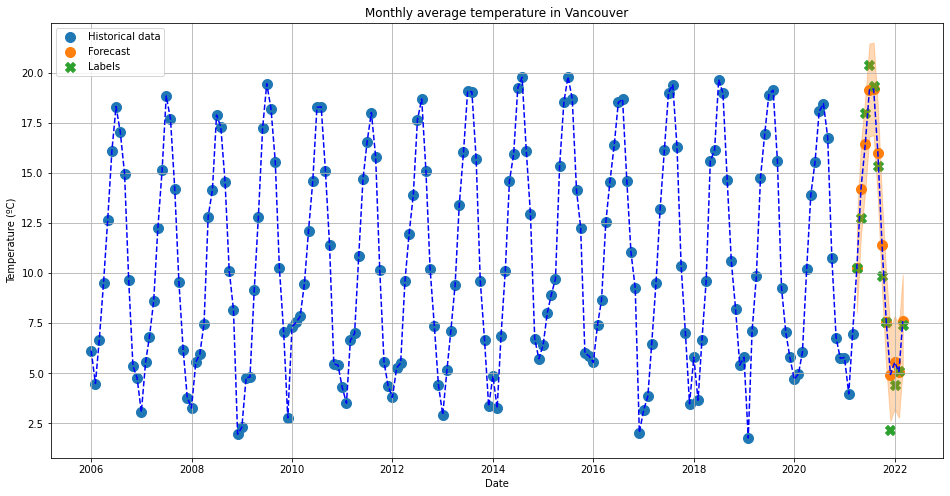

In [19]:
predict = sarima.get_forecast(steps = 12).summary_frame(alpha = .05)
res = pd.concat([endog, predict['mean']])

_, ax = plt.subplots()
plt.scatter(endog_date, endog, label = 'Historical data')
plt.scatter(predict_date, predict['mean'], label = 'Forecast')
plt.scatter(labels_date, labels, marker = 'X', label = 'Labels')
plt.plot(pd.concat([endog_date, predict_date]), res, 'b--')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Temperature (ºC)')
plt.title('Monthly average temperature in Vancouver')
ax.fill_between(predict_date, predict['mean_ci_lower'],
                predict['mean_ci_upper'], color='tab:orange', alpha = 0.3);
plt.show()

However, the error measures (MAD = 0.9064 ºC, MSE = 1.516 ºC² and MAPE = 17.23%) reveals that the SARIMA$(1, 0, 0)\times(2, 1, 2)_{12}$ model had a performance marginally superior to the previous model. Furthermore, according to its Ljung-Box statistic, the model describes adequately the time series with a probability bigger than the SARIMA$(1, 0, 0)\times (0, 1, 2)_{12}$ model. Based on the exposed reasons, the SARIMA$(1, 0, 0)\times(2, 1, 2)_{12}$ model was chosen as the best result of in the current modeling procedure.

In [20]:
res = (labels - predict['mean']).values

print('MAD: ', np.mean(np.abs(res)), 'ºC')
print('MSE:', np.mean((res)**2), 'ºC²')
print('MAPE: ', 100*np.mean(np.abs(res)/labels.values), '%')

MAD:  0.9064038758624573 ºC
MSE: 1.5163535815701874 ºC²
MAPE:  17.23220907072217 %


The chosen model was used to identify the dynamics of the whole temperature time series. Although the maximum likelihood estimator failed to obtain an optimum set of parameters, it is possible to see that these parameters furnish an adequate model of the monthly average temperature. The p-value of the Ljung-Box (0.09) is bigger than the threshold assumed in this work. Moreover, it is possible to say that the uncertainties in the results are not larger than the observed for the previous model. It is possible to check in the Statespace Model Results that the standard errors of the parameters are very similar.

In [21]:
sarima = SARIMAX(month_df['tavg'], trend = 'c', order = (1, 0, 0),
                 seasonal_order = (2, 1, 2, 12)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               tavg   No. Observations:                  195
Model:             SARIMAX(1, 0, 0)x(2, 1, 2, 12)   Log Likelihood                -293.483
Date:                            Fri, 15 Apr 2022   AIC                            600.966
Time:                                    23:55:57   BIC                            623.432
Sample:                                         0   HQIC                           610.072
                                            - 195                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0933      0.044      2.143      0.032       0.008       0.179
ar.L1          0.2251      0.071      3.167      0.002       0.086       0.364
ar.S.L12      -0.8635      0.394     -2.191      0.028      -1.636      -0.091
ar.S.L24       0.1363      0.075      1.816      0.069      -0.011       0.283
ma.S.L12      -0.0036     45.576  -7.93e-05      1.000     -89.330      89.323
ma.S.L24      -0.9964     45.336     -0.022      0.982     -89.853      87.860
sigma2         1.1946     54.325      0.022      0.982    -105.280     107.669
===================================================================================
Ljung-Box (Q):                       52.43   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.09   Prob(JB):                         0.06
Heteroskedasticity (H):               0.79   Skew:                            -0.18
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMA$(1, 0, 0)\times (2, 1, 2)_{12}$ model was used to forecast the temperature time series 12 steps ahead, comprising the period from March of 2022 up to March of 2023. The mean values and confidence intervals of the forecasts are exposed in the next figure. According to the predictions, it is not very likely that the winter temperatures in this period will be lower than the observed in the historical cold wave in December of 2021. On the other hand, it is very reasonable to consider that the next summer temperatures may be close to the observed during the heat dome between June and July of 2021. As can be seen, the confidence interval of the predictions overcome considerably the temperatures for the same period in the last year.

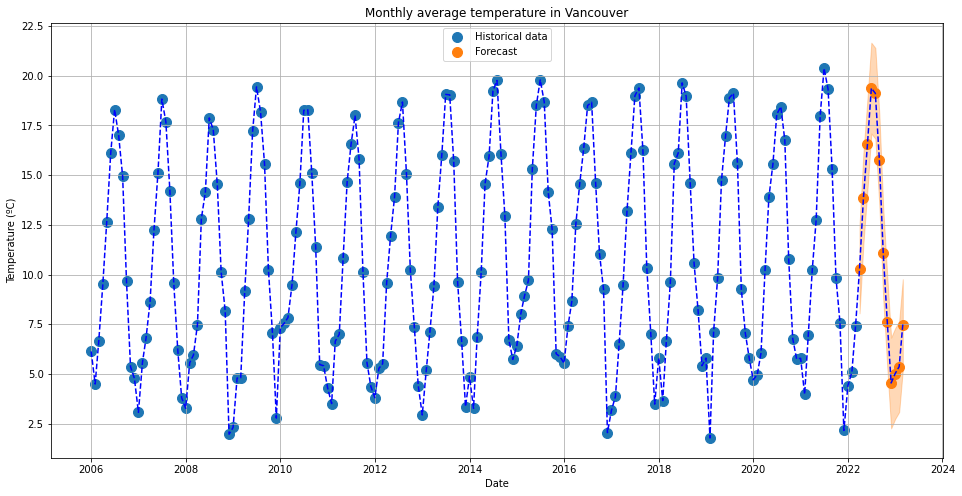

In [22]:
predict = sarima.get_forecast(steps = 12).summary_frame(alpha = .05)
res = pd.concat([month_df['tavg'], predict['mean']])

predict_date = pd.Series(
    pd.date_range(datetime(2022, 4, 1),
                  datetime(2023, 4, 1), freq = 'm')).apply(
                      lambda d: d.replace(day = 1))

_, ax = plt.subplots()
plt.scatter(month_df['date'], month_df['tavg'], label = 'Historical data')
plt.scatter(predict_date, predict['mean'], label = 'Forecast')
plt.plot(pd.concat([month_df['date'], predict_date]), res, 'b--')
plt.legend(loc = 'upper center')
plt.xlabel('Date')
plt.ylabel('Temperature (ºC)')
plt.title('Monthly average temperature in Vancouver')
ax.fill_between(predict_date, predict['mean_ci_lower'],
                predict['mean_ci_upper'], color='tab:orange', alpha = 0.3);
plt.show()

Based on the results of the modeling approach it is possible to conclude that the hypothesis of linear dynamics, underlying on the seasonal behavior furnishes a good description of the analyzed monthly average temperature. The only exception to this, during the forecasting of the time series, was observed to a month in which rank 4+ anomalies were detected. Thus, it is possible to assume that the model is able to forecast, with reasonable accuracy, the temperatures for months still not contemplated in the historical data.

## Conclusions

This work showed that it is possible to obtain a further understanding of the data in climate time series by means monitoring anomalies and modeling the seasonal behaviors along long-term periods. From the principal results of the presented report, it can be cited that:

* An EWMA time series can be used as an estimate of the time series expected values. As a validation of the approach, the anomalous behaviors detected through the comparison with the EWMA time series match phenomena, associated with excessively high and low temperatures, in the registered climate history.
* The temperature time series could be successfully identified by a linear model of seasonal order. The forecasts along a one year period presented average errors of 0.9064 ºC and relative error of 17.23%.

## References

ALI, A. **It could be the coldest Christmas in recorded history for Vancouver** (2021). In: <https://dailyhive.com/vancouver/coldest-christmas-history-vancouver> Accessed in March 15 2022.

BOX, G. E. P.; JENKINS, G. M.; REINSEL, G. C.; LJUNG, G. M. **Time Series Analysis**: Forecasting and Control. 5. ed. Wiley: Hoboken (USA), 2016.

LINDSAY, B. **64 temperature records smashed in B.C.** (2015). In: <https://vancouversun.com/news/metro/64-temperature-records-smashed-in-bc> Accessed in March 15 2022.

ROSENTHAL, Z. **What is a heat dome?** (2021). In: <https://www.accuweather.com/en/weather-news/what-is-a-heat-dome/971124> Accessed in March 15 2022.

SCHMUNK. R. **595 people were killed by heat in B.C. this summer, new figures from coroner show** (2021). In: <https://www.cbc.ca/news/canada/british-columbia/bc-heat-dome-sudden-deaths-revised-2021-1.6232758> Accessed in March 15 2022.